# Adding Error Bounds in Python

---

<br>

Copyright 2024 Mike Augspurger, (License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/))


<br>

---


This notebook provides instructions for adding error bounds to a fitted curve.

### Importing the Data (Option 1: Spreadsheet Import)

Let's say you have a set of data in a spreadsheet (we'll use Excel here).   For the sake of simplicity, make sure your data looks something like this (your headings can be whatever you prefer, but the temperature values should be in order from lowest to highest):

<br>

<center>
<img src = https://github.com/MAugspurger/Exper_Eng/raw/main/Labs_and_Sensors/Images/Example_spreadsheet_olive.PNG width = 200>
</center>

<br>

First, we want to import this data.  The following cell will connect the Colab environment to your Google drive:

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In the next cell, change the `home` variable to the location of the data file on your Google drive, and change `filename` to your filename:

In [3]:
import pandas as pd
import numpy as np

home = '/gdrive/MyDrive/Teaching/Engr_290/Notebooks_290/Labs_and_Sensors/Arrhenius_Curve/'
filename = 'rotational_viscom_data'
file = home + filename + ".xlsx"
vis_data = pd.read_excel(file)
vis_data

,Temperature,Viscosity
0,23.7,40.1
1,24.8,38.8
2,27.0,37.2
3,31.7,30.2
4,37.0,27.1
5,37.8,25.5
6,38.9,25.0
7,45.0,21.4
8,47.0,19.2
9,49.0,21.1


The data is stored as a DataFrame (a "spreadsheet" that is part of the Pandas library) called `vis_data`.  For ease of use, we'll change the titles of the columns, and put the data into a Series (a simpler data storage device in the Pandas library).  This will allow us to easily plot the data:

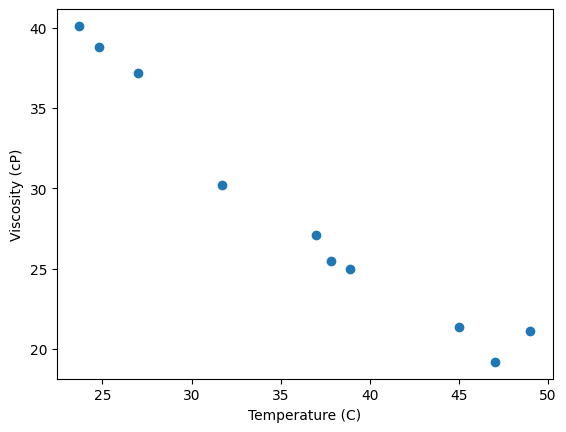

In [8]:
vis_data.columns = ['temp','visc']
experimental_data_spread = pd.Series(data=vis_data.visc.values,index=vis_data.temp.values)
experimental_data_spread.plot(style='o', ylabel='Viscosity (cP)', xlabel='Temperature (C)');

### Importing the Data (Option 2: Direct Entry)

If you have a lot of data points, a spreadsheet is really the way to go.  But if your data set is small, it might be easier to enter the data directly into the Python environment.

<br>

We can do that by creating an *array* for both the index and the values, and using the two lists to create a Series.   Arrays are foundational data objects in the NumPy library:

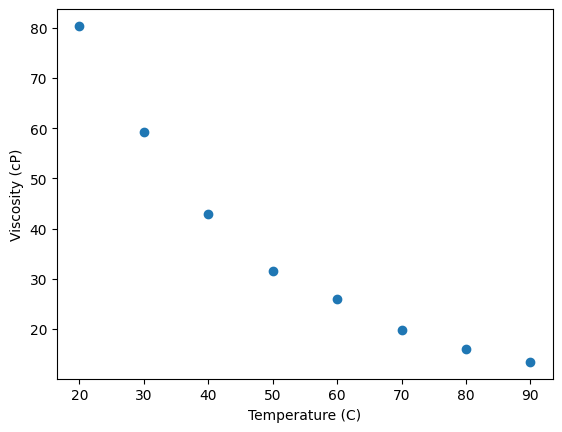

In [4]:
# Enter experimental data
temps = np.array([20,30,40,50,60,70,80,90])
vals = ([80.4, 59.3, 42.8, 31.6, 26, 19.7, 16, 13.4])

# Put the data in a Series
experimental_data_direct = pd.Series(data=vals,index=temps)
experimental_data_direct.plot(style='o', ylabel='Viscosity (cP)', xlabel='Temperature (C)');

### Defining the Arrhenius curve

Next we need to fit a line.  Just as we did when we calibrated the Zahn cup, we'll set up a function of the form we want (an Arrhenius curve) and then use a least squares algorithm to find the best coefficients for the fit.

<br>

Remember that we could adapt this for any type of curve: if we wanted to fit a quadratic or linear curve, we could simply replace the `arrhenius()` function with a different function!

In [5]:
def arrhenius(mu_0,B,T_array):
    # Choose the best way to calculate the viscosity value
    mu = mu_0 * np.exp(B/(T_array+273.15))

    # Choose the appropriate return line
    return pd.Series(index = T_array,data=mu)


Remember that to use least squares, we need to define an deviation function: a function that finds the difference between the curve and the data at each point (this is written as $y_i - y_c$ in our class notes).

In [6]:
def deviation_func(params, data):
    arrh = arrhenius(params[0],params[1],data.index)
    errors = arrh - data
    return errors

And now we can minimize the deviation between the known data and the fitted curve by calling `leastsq()`, a function that is part of the SciPy library. We'll add a first guess at the parameters, which doesn't need to be accurate but should not be too outlandish (this may take some experimentation):

In [9]:
import scipy.optimize as spo

#####  NOTICE: Uncomment line 4 or 5 based upon the import option you used above #####
experimental_data = experimental_data_spread
#experimental_data = experimental_data_direct

# Find the optimized coefficients
params = [0.01,1300]
best_params, fit_details = spo.leastsq(deviation_func, params, experimental_data)
best_params



array([3.28540614e-03, 2.79340976e+03])

Finally, we can plot the fitted curve using the optimized parameters, and compare the fitted curve with the experimental data points:

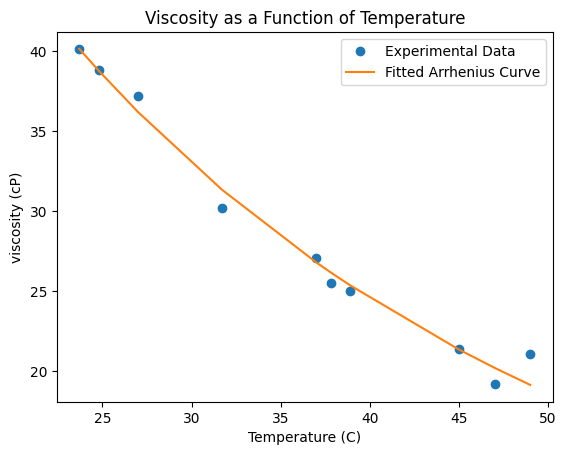

In [10]:
# Create the fitted curve using the optimized parameters
arrh_fitted = arrhenius(best_params[0],best_params[1],experimental_data.index)

# Plot the known data points as points
experimental_data.plot(ylabel = 'viscosity (cP)', xlabel = 'Temperature (C)',
           title = 'Viscosity as a Function of Temperature',
                style = 'o', label='Experimental Data',legend=True);

# Plot the fitted curve as a curve
arrh_fitted.plot(label='Fitted Arrhenius Curve', legend =True);

### Plotting with error bars

To find the uncertainty in the fitted curve, you will need to find the standard error of the fit (see step 4 of the Zahn cup calibration process).  

<br>

$$S_{xy}= \sqrt{\frac{1}{\nu} \sum_{i=1}^{N} (y_{i}-y_{curve,i})^2}$$

<br>

If you didn't calibrate the Zahn cup, note that you can solve this in a code cell by recognizing that $y_i$ are the viscosity values of each known experimental data point (`experimental_data`), and that $y_{curve,i}$ are the fitted values at the known temperatures (`arrh_fitted`).

<br>

Once you have the standard error of the fit, you need to find the random uncertainty at a 95% confidence level:

<br>

$$u_{rand} = t_{\nu,\%} \frac{S_{xy}}{\sqrt{N}}$$

<br>  

Finally, you might need to combine the random uncertainty $u_{rand}$ with other uncertainties to get a total uncertainty $u_{total}$.  For instance, if you calibrated the Zahn cup and found a calibration uncertainty, you could combine the two in quadrature:

<br>

$$u_{total} = \sqrt{u_{rand}^2 + u_{calibration}^2}$$

<br>

Once you have the uncertainty $u_{total}$, we want to draw a "bounds" around the fit.  This is because the uncertainty in a the fit does *not* tell us the error in each data point, but instead tells us the potential error in the fit: how far off the fit might be.  

<br>

So we want to draw our error bars not from the data points, but from the curve itself. We can do that using MatPlotLib, which is a powerful tool for plotting in Python (and in fact is the code on which our Series and DataFrame plot() functions are built).  `fill_between` defines an upper and lower bound for the curve, and shades in the region.  `alpha` defines the transparency of the shaded region.

<br>

Just for the sake of the example, we'll set our uncertainty to an arbitrary value of $3.0 ~cP$:



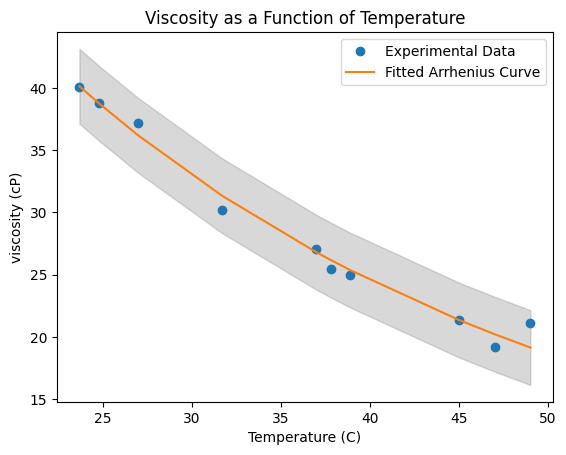

In [11]:
import matplotlib.pyplot as plt
unc = 3.0
experimental_data.plot(ylabel = 'viscosity (cP)', xlabel = 'Temperature (C)',
           title = 'Viscosity as a Function of Temperature',
                style = 'o', label='Experimental Data',legend=True);
arrh_fitted.plot(label='Fitted Arrhenius Curve', legend =True);
plt.fill_between(arrh_fitted.index, arrh_fitted.values - unc, arrh_fitted.values + unc,
                 color = 'gray', alpha = 0.3);

So now that you have a model for this type of plot, you can use it to display your own viscosity data.  Yippee!